# Pre-processing


Aqui aplicamos os filtros de pré-processamento para refinar os dados de espectroscopia. Os filtros utilizados serão a Correção Multiplicativa de Espalhamento (MSC), Padronização Normal de Sinal  (SNV) e a primeira derivada de Savitzky-Golay.

# Imports


In [163]:
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, detrend
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression

# Load data

In [164]:
def load_data(filepath):
    df = pd.read_excel(filepath, engine="openpyxl")
    metadata = df.iloc[:, [0,1,2,3,4,6]]  # Seleciona colunas 1,2,3,4,5 e 7
    wavelengths = df.iloc[:, 7:]  # Da oitava coluna até o fim
    return metadata, wavelengths

# Filter's algorithm

In [165]:
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

In [166]:
def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [167]:
def savitzky_golay(X, window_size=41, poly_order=2, deriv_order=1):
    """Savitzky-Golay (generalizado para qualquer derivada)."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)



In [176]:
class OrthogonalCorrection(BaseEstimator, TransformerMixin):
    """
    Correção Ortogonal de Sinal (OSC/OPLS).
    [CORRIGIDO] Corrigido erro de dimensão de matriz na subtração do componente ortogonal.
    """
    def __init__(self, n_components=1):
        self.n_components = n_components

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel() # .ravel() para garantir que y seja 1D
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover variação ortogonal (CORREÇÃO AQUI)
            # Removemos o .T de p_ortho
            self.X_corr_ -= np.dot(t_ortho, p_ortho) 
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        return self

    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            # Remover variação ortogonal (CORREÇÃO AQUI)
            # Removemos o .T de p_ortho_[i]
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.X_corr_

In [169]:
def wavelet_transform(X, wavelet='db4', level=4):
    """
    Wavelet Transform para Denoising.
    """
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposição Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. Cálculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplicação do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstrução do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

In [170]:
def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpolação linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

In [171]:
def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0) # Usa o espectro médio como referência
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ≈ a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

# Plot and save

In [173]:
def plot_spectra(wavelengths, data, title, save_path):
    """Plota e salva os espectros processados."""
    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, data.T, alpha=0.5)
    plt.xlabel("Comprimento de onda (nm)")
    plt.ylabel("Intensidade / Absorbância")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(save_path)
    plt.close()


def save_processed_data(metadata, processed_data, filename, output_folder, wavelengths):
    """Salva os dados processados em um arquivo Excel."""
    processed_df = pd.DataFrame(processed_data, columns=wavelengths)
    result = pd.concat([metadata.reset_index(drop=True), processed_df.reset_index(drop=True)], axis=1)
    result.to_excel(os.path.join(output_folder, filename), index=False)
    print(f"-> Dados salvos em: {filename}")


# Main

In [177]:
def main():
    # ------------------- Configuração de Pastas -------------------
    filepath = r"C:\Users\luyza\Documents\ML-spectroscopy-analysis\Data\dataset_cotton_fruit.xlsx"
    
    root_folder = os.path.dirname(os.path.dirname(filepath))
    # Pasta raiz para todos os espectros filtrados
    base_output_folder = os.path.join(root_folder, "Filtered_Spectra")
    
    # ------------------- Carregamento dos Dados -------------------
    metadata, wavelengths_df = load_data(filepath)
    X_raw = wavelengths_df.values
    wavelengths_axis = wavelengths_df.columns.astype(float).values
    
    target_columns = ['SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBS (%)']

    # --- Dicionário de Pipelines de Pré-processamento ---
    # Cada chave é o nome do arquivo de saída.
    # O valor é uma lista de tuplas (função, parâmetros).
    # 'X' representa os dados atuais, 'y' a variável alvo, 'w' os comprimentos de onda.
    
    pipelines = {
        # --- Seus filtros originais ---
        "msc": [(msc, {})],
        "snv": [(snv, {})],
        "sg_d1": [(savitzky_golay, {'deriv_order': 1})],
        "snv_detrend_sg_d1": [(snv, {}), (detrend, {}), (savitzky_golay, {'deriv_order': 1, 'window_size': 41, 'poly_order': 1})],
        "wavelet_denoising": [(wavelet_transform, {'wavelet': 'db4', 'level': 4})],
        "continuum_removal": [(continuum_removal, {'wavelengths': 'w'})],
        "emsc": [(emsc, {})],
    }

    # --- Dicionário de Pipelines (Dependentes de 'y', como OSC) ---
    pipelines_y_dependent = {
        # OSC puro
        "osc_pure": [(OrthogonalCorrection, {'n_components': 1})],
        
        # Suas combinações originais com OSC
        "msc_sg_osc": [
            (msc, {}), 
            (savitzky_golay, {'deriv_order': 1, 'window_size': 41, 'poly_order': 1}), 
            (OrthogonalCorrection, {'n_components': 1})
        ],
        "snv_sg_osc": [
            (snv, {}), 
            (savitzky_golay, {'deriv_order': 1, 'window_size': 41, 'poly_order': 1}), 
            (OrthogonalCorrection, {'n_components': 1})
        ],
        "opls2_snv_sg_d1": [(snv, {}), (savitzky_golay, {'deriv_order': 1, 'window_size': 41, 'poly_order': 1}), (OrthogonalCorrection, {'n_components': 2})],
        "opls1_snv_sg_d1": [(snv, {}), (savitzky_golay, {'deriv_order': 1, 'window_size': 41, 'poly_order': 1}), (OrthogonalCorrection, {'n_components': 1})]
    }

    # --- Executando os pipelines independentes de 'y' ---
    print("Iniciando pipelines independentes da variável alvo...")
    for name, steps in pipelines.items():
        print(f"\nExecutando pipeline: {name}")

        pipeline_output_folder = os.path.join(base_output_folder, name)
        pipeline_plots_folder = os.path.join(pipeline_output_folder, "plots")
        os.makedirs(pipeline_plots_folder, exist_ok=True)
        
        X_processed = X_raw.copy()
        for func, params in steps:
            if 'wavelengths' in params and params['wavelengths'] == 'w':
                params['wavelengths'] = wavelengths_axis
            X_processed = func(X_processed, **params)

        save_processed_data(metadata, X_processed, f"{name}.xlsx", pipeline_output_folder, wavelengths_axis)
        plot_spectra(wavelengths_axis, X_processed, f"Espectros - {name.upper()}", os.path.join(pipeline_plots_folder, f"{name}.png"))
    
    print("\nIniciando pipelines dependentes da variável alvo (OSC/OPLS)...")
    for name, steps in pipelines_y_dependent.items():
        print(f"\n----- Pipeline: {name} -----")
        
        pipeline_output_folder = os.path.join(base_output_folder, name)
        pipeline_plots_folder = os.path.join(pipeline_output_folder, "plots")
        os.makedirs(pipeline_plots_folder, exist_ok=True)
        
        for target_col in target_columns:
            print(f"  - Processando para o alvo: {target_col}")
            y_target = metadata[target_col].values
            
            X_processed = X_raw.copy()
            for func, params in steps:
                if func.__name__ == 'OrthogonalCorrection':
                    X_processed = func(**params).fit_transform(X_processed, y_target)
                else:
                    X_processed = func(X_processed, **params)
            
            sanitized_name = target_col.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')
            filename = f"{name}_{sanitized_name}.xlsx"
            plot_filename = f"{name}_{sanitized_name}.png"
            
            save_processed_data(metadata, X_processed, filename, pipeline_output_folder, wavelengths_axis)
            plot_spectra(wavelengths_axis, X_processed, f"Espectros - {name.upper()} para {target_col}", os.path.join(pipeline_plots_folder, plot_filename))

    print("\n✅ Todos os pipelines foram executados com sucesso na nova estrutura de pastas!")



In [178]:
if __name__ == "__main__":
     main()

Iniciando pipelines independentes da variável alvo...

Executando pipeline: msc
-> Dados salvos em: msc.xlsx

Executando pipeline: snv
-> Dados salvos em: snv.xlsx

Executando pipeline: sg_d1
-> Dados salvos em: sg_d1.xlsx

Executando pipeline: snv_detrend_sg_d1
-> Dados salvos em: snv_detrend_sg_d1.xlsx

Executando pipeline: wavelet_denoising
-> Dados salvos em: wavelet_denoising.xlsx

Executando pipeline: continuum_removal
-> Dados salvos em: continuum_removal.xlsx

Executando pipeline: emsc
-> Dados salvos em: emsc.xlsx

Iniciando pipelines dependentes da variável alvo (OSC/OPLS)...

----- Pipeline: osc_pure -----
  - Processando para o alvo: SST
-> Dados salvos em: osc_pure_SST.xlsx
  - Processando para o alvo: PH
-> Dados salvos em: osc_pure_PH.xlsx
  - Processando para o alvo: AT
-> Dados salvos em: osc_pure_AT.xlsx
  - Processando para o alvo: FIRMEZA (N)
-> Dados salvos em: osc_pure_FIRMEZA.xlsx
  - Processando para o alvo: UBS (%)
-> Dados salvos em: osc_pure_UBS.xlsx

----- P

# Testes componentes para o OSC

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

In [9]:
# ---------- Função OSC manual ----------
def osc(X, Y, n_components=2):
    X_corrected = np.copy(X)
    for _ in range(n_components):
        pls = PLSRegression(n_components=1)
        pls.fit(X_corrected, Y.reshape(-1, 1))
        t = pls.x_scores_
        p = pls.x_loadings_
        w = np.dot(t.T, Y.reshape(-1, 1)) / np.dot(t.T, t)
        t_ortho = t - np.dot(Y.reshape(-1, 1), w.T)
        p_ortho = np.dot(t_ortho.T, X_corrected) / np.dot(t_ortho.T, t_ortho)
        X_corrected -= np.dot(t_ortho, p_ortho)
    return X_corrected


In [10]:
def preprocess(X):
    X_snv = snv(X)
    X_sg = savgol_filter(X_snv, window_length=41, polyorder=1, deriv=1, axis=1)
    return X_sg

In [61]:
def rmsecv_osc_pls(
    X, Y,
    max_osc_components=5,
    pls_components=5,
    cv_splits=5,
    random_seed=42,
    use_snv=True,
    use_sg=True,
    sg_window=41,
    sg_polyorder=1
):
    np.random.seed(random_seed)
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_seed)
    
    rmsecv_list = []

    for n_osc in range(0, max_osc_components + 1):
        rmse_fold = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # --- Pré-processamento ---
            if use_snv:
                X_train = snv(X_train)
                X_test = snv(X_test)

            if use_sg:
                X_train = savitzky_golay(X_train, window_size=sg_window, poly_order=sg_polyorder)
                X_test = savitzky_golay(X_test, window_size=sg_window, poly_order=sg_polyorder)

            # --- Aplica OSC no treino ---
            if n_osc > 0:
                X_train_osc = osc(X_train, Y_train, n_components=n_osc)
                X_test_osc = X_test  # No OSC, apenas os dados de treino são corrigidos
            else:
                X_train_osc = X_train
                X_test_osc = X_test

            # --- PLS ---
            pls = PLSRegression(n_components=pls_components)
            pls.fit(X_train_osc, Y_train)

            # --- Previsão ---
            Y_pred = pls.predict(X_test_osc).ravel()
            rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
            rmse_fold.append(rmse)

        rmsecv = np.mean(rmse_fold)
        print(f"OSC components: {n_osc} - RMSECV: {rmsecv:.4f}")
        rmsecv_list.append(rmsecv)

    return rmsecv_list


In [62]:
filepath = r"C:\Users\luyza\Documents\ML-spectroscopy-analysis\Data\Original\dataset_cotton_fruit.xlsx"
    
root_folder = os.path.dirname(os.path.dirname(filepath))  
output_folder = os.path.join(root_folder, "Processed")
os.makedirs(output_folder, exist_ok=True)

metadata, wavelengths = load_data(filepath)

print("Antes de ajustar shape:", wavelengths.shape)

if wavelengths.shape[0] > wavelengths.shape[1]:
    wavelengths = wavelengths.T

print("Depois de ajustar shape:", wavelengths.shape)

Y_target = metadata['FIRMEZA (N)'].values

print(f"X shape: {wavelengths.shape}")
print(f"Y shape: {Y_target.shape}")
assert wavelengths.shape[0] == Y_target.shape[0], "X e Y devem ter o mesmo número de amostras"


Antes de ajustar shape: (250, 2151)
Depois de ajustar shape: (250, 2151)
X shape: (250, 2151)
Y shape: (250,)


OSC components: 0 - RMSECV: 1.1592
OSC components: 1 - RMSECV: 4.7808
OSC components: 2 - RMSECV: 4.5225
OSC components: 3 - RMSECV: 4.3787
OSC components: 4 - RMSECV: 4.6501
OSC components: 5 - RMSECV: 4.1877


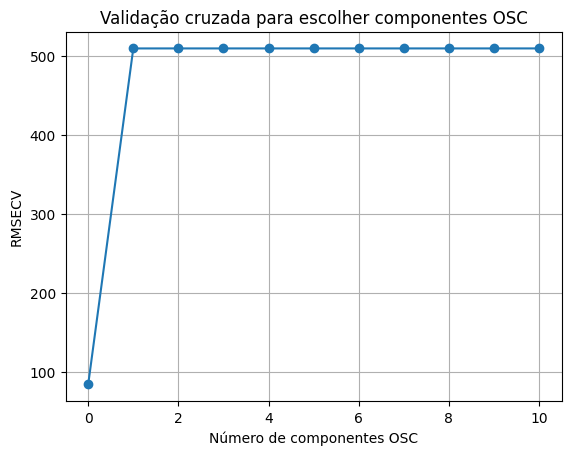

In [63]:
X = wavelengths.values
y = Y_target
# Execute a validação cruzada
rmsecv_osc_pls(
    X=wavelengths.values,
    Y=metadata["SST"].values,
    max_osc_components=5,
    pls_components=5,
    use_snv=True,
    use_sg=True,
    sg_window=41,
    sg_polyorder=1
)

plt.plot(range(0, len(rmsecv_scores)), rmsecv_scores, marker='o')
plt.xlabel('Número de componentes OSC')
plt.ylabel('RMSECV')
plt.title('Validação cruzada para escolher componentes OSC')
plt.grid(True)
plt.show()

# Analisando os filtros

### SST

In [179]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorar avisos que podem aparecer durante a convergência do PLS
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# --- CONFIGURAÇÃO DA ANÁLISE ---
# =============================================================================

# 1. Defina o caminho base do seu projeto
base_dir = Path(r"C:\Users\luyza\Documents\ML-spectroscopy-analysis")

# 2. Defina a variável-alvo que você quer usar para esta avaliação.
#    Escolha a mais importante para o seu projeto.
PRIMARY_TARGET_VARIABLE = "SST"

# 3. Defina o número máximo de componentes do PLS a serem testados.
#    Um valor entre 15 e 25 é geralmente suficiente.
MAX_PLS_COMPONENTS = 20

# =============================================================================
# --- INÍCIO DO SCRIPT DE AVALIAÇÃO ---
# =============================================================================

# Diretório raiz que contém todos os espectros filtrados
filtered_data_root_dir = base_dir / "Filtered_Spectra"

# Lista para armazenar os resultados finais de cada filtro
all_filter_results = []

print("="*60)
print(f"INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: '{PRIMARY_TARGET_VARIABLE}'")
print("="*60)

if not filtered_data_root_dir.exists():
    raise FileNotFoundError(f"Diretório de dados filtrados não encontrado: {filtered_data_root_dir}")

# Sanitiza o nome do alvo para comparar com nomes de arquivos
sanitized_target = PRIMARY_TARGET_VARIABLE.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')

# Loop 1: Itera sobre as pastas de cada tipo de filtro (ex: 'msc', 'snv_sg_osc')
for filter_folder_name in os.listdir(filtered_data_root_dir):
    filter_folder_path = filtered_data_root_dir / filter_folder_name
    if not filter_folder_path.is_dir():
        continue

    # Loop 2: Itera sobre os arquivos .xlsx dentro da pasta do filtro
    for filename in os.listdir(filter_folder_path):
        if not filename.endswith('.xlsx') or filename.startswith('~'):
            continue

        base_name = Path(filename).stem
        
        # Condição para processar:
        # 1. Se o arquivo foi gerado para o alvo específico (ex: '..._SST.xlsx')
        # 2. Ou se é um filtro independente (ex: 'msc.xlsx')
        is_target_dependent_match = base_name.endswith(f"_{sanitized_target}")
        is_independent_filter = "_" not in base_name or not any(char.isdigit() for char in base_name.split("_")[-1])

        # A lógica acima assume que filtros independentes não terminam com _NOMEALVO
        # Esta é uma simplificação, mas deve funcionar para a sua estrutura.
        # Ajuste se seus nomes de arquivo forem diferentes.
        
        # Um teste mais simples: se for dependente, precisa bater com o alvo. Se for independente, processe.
        # Vamos refinar a lógica de identificação
        parts = base_name.split('_')
        is_independent = len(parts) <= 2 # Heurística: nomes como 'msc', 'sg_d1' são independentes.
                                         # Nomes como 'msc_sg_osc_SST' não são.

        if not is_independent and not is_target_dependent_match:
             continue # Pula arquivos dependentes que não são do nosso alvo de interesse
        
        filepath = filter_folder_path / filename
        print(f"\n--- Analisando: {filepath.relative_to(base_dir)} ---")

        # Carrega os dados
        df = pd.read_excel(filepath)

        if PRIMARY_TARGET_VARIABLE not in df.columns:
            print(f"  Aviso: Coluna '{PRIMARY_TARGET_VARIABLE}' não encontrada. Pulando.")
            continue
        
        X = df.iloc[:, 6:] # Dados espectrais (ajuste o índice se necessário)
        y = df[PRIMARY_TARGET_VARIABLE]
        
        if y.isnull().any():
            not_null_mask = y.notnull()
            X = X[not_null_mask]
            y = y[not_null_mask]
            print(f"  Aviso: {sum(~not_null_mask)} amostras com valores nulos em Y foram removidas.")

        # Normaliza os dados X (boa prática para PLS)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Loop para encontrar o melhor número de componentes para este filtro
        best_rmse = float('inf')
        best_n_components = 0
        
        for n in range(1, MAX_PLS_COMPONENTS + 1):
            pls = PLSRegression(n_components=n)
            scores = cross_val_score(
                pls, X_scaled, y, 
                cv=5, scoring='neg_root_mean_squared_error'
            )
            current_rmse = -np.mean(scores)
            
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_n_components = n
        
        print(f"  -> Melhor Resultado: RMSE = {best_rmse:.4f} com {best_n_components} componentes.")
        
        all_filter_results.append({
            "Filtro": filepath.relative_to(filtered_data_root_dir),
            "Melhor N Componentes": best_n_components,
            "RMSE (Validação Cruzada)": best_rmse
        })

# --- GERAÇÃO DO RELATÓRIO FINAL ---
print("\n\n" + "="*70)
print(f"RANKING FINAL DE FILTROS PARA '{PRIMARY_TARGET_VARIABLE}' (Menor RMSE é Melhor)")
print("="*70)

if not all_filter_results:
    print("Nenhum resultado foi gerado. Verifique os caminhos e o nome da variável alvo.")
else:
    results_df = pd.DataFrame(all_filter_results)
    results_df_sorted = results_df.sort_values(by="RMSE (Validação Cruzada)", ascending=True)
    
    # Formatando o nome do filtro para melhor visualização
    results_df_sorted["Filtro"] = results_df_sorted["Filtro"].apply(lambda p: str(p))
    
    print(results_df_sorted.to_string(index=False))
    
    best_filter = results_df_sorted.iloc[0]
    print("\n" + "-"*70)
    print(f"🏆 Filtro mais promissor: {best_filter['Filtro']}")
    print(f"   Com um RMSE de {best_filter['RMSE (Validação Cruzada)']:.4f} usando {best_filter['Melhor N Componentes']} componentes.")
    print("-" * 70)

print("\n✅ Avaliação concluída!")

INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: 'SST'

--- Analisando: Filtered_Spectra\continuum_removal\continuum_removal.xlsx ---
  -> Melhor Resultado: RMSE = 1.4078 com 11 componentes.

--- Analisando: Filtered_Spectra\emsc\emsc.xlsx ---
  -> Melhor Resultado: RMSE = 1.2068 com 15 componentes.

--- Analisando: Filtered_Spectra\msc\msc.xlsx ---
  -> Melhor Resultado: RMSE = 1.2068 com 15 componentes.

--- Analisando: Filtered_Spectra\msc_sg_osc\msc_sg_osc_SST.xlsx ---
  -> Melhor Resultado: RMSE = 1.1399 com 13 componentes.

--- Analisando: Filtered_Spectra\opls1_snv_sg_d1\opls1_snv_sg_d1_SST.xlsx ---
  -> Melhor Resultado: RMSE = 1.1700 com 13 componentes.

--- Analisando: Filtered_Spectra\opls2_snv_sg_d1\opls2_snv_sg_d1_SST.xlsx ---
  -> Melhor Resultado: RMSE = 1.0738 com 11 componentes.

--- Analisando: Filtered_Spectra\osc_pure\osc_pure_SST.xlsx ---
  -> Melhor Resultado: RMSE = 1.3555 com 15 componentes.

--- Analisando: Filtered_Spectra\sg_d1\sg_d1.xlsx ---
  -> Melhor Resul

### AT

In [180]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorar avisos que podem aparecer durante a convergência do PLS
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# --- CONFIGURAÇÃO DA ANÁLISE ---
# =============================================================================

# 1. Defina o caminho base do seu projeto
base_dir = Path(r"C:\Users\luyza\Documents\ML-spectroscopy-analysis")

# 2. Defina a variável-alvo que você quer usar para esta avaliação.
#    Escolha a mais importante para o seu projeto.
PRIMARY_TARGET_VARIABLE = "AT"

# 3. Defina o número máximo de componentes do PLS a serem testados.
#    Um valor entre 15 e 25 é geralmente suficiente.
MAX_PLS_COMPONENTS = 20

# =============================================================================
# --- INÍCIO DO SCRIPT DE AVALIAÇÃO ---
# =============================================================================

# Diretório raiz que contém todos os espectros filtrados
filtered_data_root_dir = base_dir / "Filtered_Spectra"

# Lista para armazenar os resultados finais de cada filtro
all_filter_results = []

print("="*60)
print(f"INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: '{PRIMARY_TARGET_VARIABLE}'")
print("="*60)

if not filtered_data_root_dir.exists():
    raise FileNotFoundError(f"Diretório de dados filtrados não encontrado: {filtered_data_root_dir}")

# Sanitiza o nome do alvo para comparar com nomes de arquivos
sanitized_target = PRIMARY_TARGET_VARIABLE.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')

# Loop 1: Itera sobre as pastas de cada tipo de filtro (ex: 'msc', 'snv_sg_osc')
for filter_folder_name in os.listdir(filtered_data_root_dir):
    filter_folder_path = filtered_data_root_dir / filter_folder_name
    if not filter_folder_path.is_dir():
        continue

    # Loop 2: Itera sobre os arquivos .xlsx dentro da pasta do filtro
    for filename in os.listdir(filter_folder_path):
        if not filename.endswith('.xlsx') or filename.startswith('~'):
            continue

        base_name = Path(filename).stem
        
        # Condição para processar:
        # 1. Se o arquivo foi gerado para o alvo específico (ex: '..._SST.xlsx')
        # 2. Ou se é um filtro independente (ex: 'msc.xlsx')
        is_target_dependent_match = base_name.endswith(f"_{sanitized_target}")
        is_independent_filter = "_" not in base_name or not any(char.isdigit() for char in base_name.split("_")[-1])

        # A lógica acima assume que filtros independentes não terminam com _NOMEALVO
        # Esta é uma simplificação, mas deve funcionar para a sua estrutura.
        # Ajuste se seus nomes de arquivo forem diferentes.
        
        # Um teste mais simples: se for dependente, precisa bater com o alvo. Se for independente, processe.
        # Vamos refinar a lógica de identificação
        parts = base_name.split('_')
        is_independent = len(parts) <= 2 # Heurística: nomes como 'msc', 'sg_d1' são independentes.
                                         # Nomes como 'msc_sg_osc_SST' não são.

        if not is_independent and not is_target_dependent_match:
             continue # Pula arquivos dependentes que não são do nosso alvo de interesse
        
        filepath = filter_folder_path / filename
        print(f"\n--- Analisando: {filepath.relative_to(base_dir)} ---")

        # Carrega os dados
        df = pd.read_excel(filepath)

        if PRIMARY_TARGET_VARIABLE not in df.columns:
            print(f"  Aviso: Coluna '{PRIMARY_TARGET_VARIABLE}' não encontrada. Pulando.")
            continue
        
        X = df.iloc[:, 6:] # Dados espectrais (ajuste o índice se necessário)
        y = df[PRIMARY_TARGET_VARIABLE]
        
        if y.isnull().any():
            not_null_mask = y.notnull()
            X = X[not_null_mask]
            y = y[not_null_mask]
            print(f"  Aviso: {sum(~not_null_mask)} amostras com valores nulos em Y foram removidas.")

        # Normaliza os dados X (boa prática para PLS)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Loop para encontrar o melhor número de componentes para este filtro
        best_rmse = float('inf')
        best_n_components = 0
        
        for n in range(1, MAX_PLS_COMPONENTS + 1):
            pls = PLSRegression(n_components=n)
            scores = cross_val_score(
                pls, X_scaled, y, 
                cv=5, scoring='neg_root_mean_squared_error'
            )
            current_rmse = -np.mean(scores)
            
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_n_components = n
        
        print(f"  -> Melhor Resultado: RMSE = {best_rmse:.4f} com {best_n_components} componentes.")
        
        all_filter_results.append({
            "Filtro": filepath.relative_to(filtered_data_root_dir),
            "Melhor N Componentes": best_n_components,
            "RMSE (Validação Cruzada)": best_rmse
        })

# --- GERAÇÃO DO RELATÓRIO FINAL ---
print("\n\n" + "="*70)
print(f"RANKING FINAL DE FILTROS PARA '{PRIMARY_TARGET_VARIABLE}' (Menor RMSE é Melhor)")
print("="*70)

if not all_filter_results:
    print("Nenhum resultado foi gerado. Verifique os caminhos e o nome da variável alvo.")
else:
    results_df = pd.DataFrame(all_filter_results)
    results_df_sorted = results_df.sort_values(by="RMSE (Validação Cruzada)", ascending=True)
    
    # Formatando o nome do filtro para melhor visualização
    results_df_sorted["Filtro"] = results_df_sorted["Filtro"].apply(lambda p: str(p))
    
    print(results_df_sorted.to_string(index=False))
    
    best_filter = results_df_sorted.iloc[0]
    print("\n" + "-"*70)
    print(f"🏆 Filtro mais promissor: {best_filter['Filtro']}")
    print(f"   Com um RMSE de {best_filter['RMSE (Validação Cruzada)']:.4f} usando {best_filter['Melhor N Componentes']} componentes.")
    print("-" * 70)

print("\n✅ Avaliação concluída!")

INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: 'AT'

--- Analisando: Filtered_Spectra\continuum_removal\continuum_removal.xlsx ---
  -> Melhor Resultado: RMSE = 0.3199 com 13 componentes.

--- Analisando: Filtered_Spectra\emsc\emsc.xlsx ---
  -> Melhor Resultado: RMSE = 0.3326 com 13 componentes.

--- Analisando: Filtered_Spectra\msc\msc.xlsx ---
  -> Melhor Resultado: RMSE = 0.3326 com 13 componentes.

--- Analisando: Filtered_Spectra\msc_sg_osc\msc_sg_osc_AT.xlsx ---
  -> Melhor Resultado: RMSE = 0.3396 com 5 componentes.

--- Analisando: Filtered_Spectra\opls1_snv_sg_d1\opls1_snv_sg_d1_AT.xlsx ---
  -> Melhor Resultado: RMSE = 0.3380 com 5 componentes.

--- Analisando: Filtered_Spectra\opls2_snv_sg_d1\opls2_snv_sg_d1_AT.xlsx ---
  -> Melhor Resultado: RMSE = 0.3205 com 2 componentes.

--- Analisando: Filtered_Spectra\osc_pure\osc_pure_AT.xlsx ---
  -> Melhor Resultado: RMSE = 0.3437 com 14 componentes.

--- Analisando: Filtered_Spectra\sg_d1\sg_d1.xlsx ---
  -> Melhor Resultado: RM

### PH

In [181]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorar avisos que podem aparecer durante a convergência do PLS
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# --- CONFIGURAÇÃO DA ANÁLISE ---
# =============================================================================

# 1. Defina o caminho base do seu projeto
base_dir = Path(r"C:\Users\luyza\Documents\ML-spectroscopy-analysis")

# 2. Defina a variável-alvo que você quer usar para esta avaliação.
#    Escolha a mais importante para o seu projeto.
PRIMARY_TARGET_VARIABLE = "PH"

# 3. Defina o número máximo de componentes do PLS a serem testados.
#    Um valor entre 15 e 25 é geralmente suficiente.
MAX_PLS_COMPONENTS = 20

# =============================================================================
# --- INÍCIO DO SCRIPT DE AVALIAÇÃO ---
# =============================================================================

# Diretório raiz que contém todos os espectros filtrados
filtered_data_root_dir = base_dir / "Filtered_Spectra"

# Lista para armazenar os resultados finais de cada filtro
all_filter_results = []

print("="*60)
print(f"INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: '{PRIMARY_TARGET_VARIABLE}'")
print("="*60)

if not filtered_data_root_dir.exists():
    raise FileNotFoundError(f"Diretório de dados filtrados não encontrado: {filtered_data_root_dir}")

# Sanitiza o nome do alvo para comparar com nomes de arquivos
sanitized_target = PRIMARY_TARGET_VARIABLE.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')

# Loop 1: Itera sobre as pastas de cada tipo de filtro (ex: 'msc', 'snv_sg_osc')
for filter_folder_name in os.listdir(filtered_data_root_dir):
    filter_folder_path = filtered_data_root_dir / filter_folder_name
    if not filter_folder_path.is_dir():
        continue

    # Loop 2: Itera sobre os arquivos .xlsx dentro da pasta do filtro
    for filename in os.listdir(filter_folder_path):
        if not filename.endswith('.xlsx') or filename.startswith('~'):
            continue

        base_name = Path(filename).stem
        
        # Condição para processar:
        # 1. Se o arquivo foi gerado para o alvo específico (ex: '..._SST.xlsx')
        # 2. Ou se é um filtro independente (ex: 'msc.xlsx')
        is_target_dependent_match = base_name.endswith(f"_{sanitized_target}")
        is_independent_filter = "_" not in base_name or not any(char.isdigit() for char in base_name.split("_")[-1])

        # A lógica acima assume que filtros independentes não terminam com _NOMEALVO
        # Esta é uma simplificação, mas deve funcionar para a sua estrutura.
        # Ajuste se seus nomes de arquivo forem diferentes.
        
        # Um teste mais simples: se for dependente, precisa bater com o alvo. Se for independente, processe.
        # Vamos refinar a lógica de identificação
        parts = base_name.split('_')
        is_independent = len(parts) <= 2 # Heurística: nomes como 'msc', 'sg_d1' são independentes.
                                         # Nomes como 'msc_sg_osc_SST' não são.

        if not is_independent and not is_target_dependent_match:
             continue # Pula arquivos dependentes que não são do nosso alvo de interesse
        
        filepath = filter_folder_path / filename
        print(f"\n--- Analisando: {filepath.relative_to(base_dir)} ---")

        # Carrega os dados
        df = pd.read_excel(filepath)

        if PRIMARY_TARGET_VARIABLE not in df.columns:
            print(f"  Aviso: Coluna '{PRIMARY_TARGET_VARIABLE}' não encontrada. Pulando.")
            continue
        
        X = df.iloc[:, 6:] # Dados espectrais (ajuste o índice se necessário)
        y = df[PRIMARY_TARGET_VARIABLE]
        
        if y.isnull().any():
            not_null_mask = y.notnull()
            X = X[not_null_mask]
            y = y[not_null_mask]
            print(f"  Aviso: {sum(~not_null_mask)} amostras com valores nulos em Y foram removidas.")

        # Normaliza os dados X (boa prática para PLS)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Loop para encontrar o melhor número de componentes para este filtro
        best_rmse = float('inf')
        best_n_components = 0
        
        for n in range(1, MAX_PLS_COMPONENTS + 1):
            pls = PLSRegression(n_components=n)
            scores = cross_val_score(
                pls, X_scaled, y, 
                cv=5, scoring='neg_root_mean_squared_error'
            )
            current_rmse = -np.mean(scores)
            
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_n_components = n
        
        print(f"  -> Melhor Resultado: RMSE = {best_rmse:.4f} com {best_n_components} componentes.")
        
        all_filter_results.append({
            "Filtro": filepath.relative_to(filtered_data_root_dir),
            "Melhor N Componentes": best_n_components,
            "RMSE (Validação Cruzada)": best_rmse
        })

# --- GERAÇÃO DO RELATÓRIO FINAL ---
print("\n\n" + "="*70)
print(f"RANKING FINAL DE FILTROS PARA '{PRIMARY_TARGET_VARIABLE}' (Menor RMSE é Melhor)")
print("="*70)

if not all_filter_results:
    print("Nenhum resultado foi gerado. Verifique os caminhos e o nome da variável alvo.")
else:
    results_df = pd.DataFrame(all_filter_results)
    results_df_sorted = results_df.sort_values(by="RMSE (Validação Cruzada)", ascending=True)
    
    # Formatando o nome do filtro para melhor visualização
    results_df_sorted["Filtro"] = results_df_sorted["Filtro"].apply(lambda p: str(p))
    
    print(results_df_sorted.to_string(index=False))
    
    best_filter = results_df_sorted.iloc[0]
    print("\n" + "-"*70)
    print(f"🏆 Filtro mais promissor: {best_filter['Filtro']}")
    print(f"   Com um RMSE de {best_filter['RMSE (Validação Cruzada)']:.4f} usando {best_filter['Melhor N Componentes']} componentes.")
    print("-" * 70)

print("\n✅ Avaliação concluída!")

INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: 'PH'

--- Analisando: Filtered_Spectra\continuum_removal\continuum_removal.xlsx ---
  -> Melhor Resultado: RMSE = 0.2749 com 20 componentes.

--- Analisando: Filtered_Spectra\emsc\emsc.xlsx ---
  -> Melhor Resultado: RMSE = 0.2202 com 18 componentes.

--- Analisando: Filtered_Spectra\msc\msc.xlsx ---
  -> Melhor Resultado: RMSE = 0.2202 com 18 componentes.

--- Analisando: Filtered_Spectra\msc_sg_osc\msc_sg_osc_PH.xlsx ---
  -> Melhor Resultado: RMSE = 0.2388 com 20 componentes.

--- Analisando: Filtered_Spectra\opls1_snv_sg_d1\opls1_snv_sg_d1_PH.xlsx ---
  -> Melhor Resultado: RMSE = 0.2410 com 20 componentes.

--- Analisando: Filtered_Spectra\opls2_snv_sg_d1\opls2_snv_sg_d1_PH.xlsx ---
  -> Melhor Resultado: RMSE = 0.2112 com 13 componentes.

--- Analisando: Filtered_Spectra\osc_pure\osc_pure_PH.xlsx ---
  -> Melhor Resultado: RMSE = 0.2311 com 20 componentes.

--- Analisando: Filtered_Spectra\sg_d1\sg_d1.xlsx ---
  -> Melhor Resultado:

### FIRMEZA (N)

In [182]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorar avisos que podem aparecer durante a convergência do PLS
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# --- CONFIGURAÇÃO DA ANÁLISE ---
# =============================================================================

# 1. Defina o caminho base do seu projeto
base_dir = Path(r"C:\Users\luyza\Documents\ML-spectroscopy-analysis")

# 2. Defina a variável-alvo que você quer usar para esta avaliação.
#    Escolha a mais importante para o seu projeto.
PRIMARY_TARGET_VARIABLE = "FIRMEZA (N)"

# 3. Defina o número máximo de componentes do PLS a serem testados.
#    Um valor entre 15 e 25 é geralmente suficiente.
MAX_PLS_COMPONENTS = 20

# =============================================================================
# --- INÍCIO DO SCRIPT DE AVALIAÇÃO ---
# =============================================================================

# Diretório raiz que contém todos os espectros filtrados
filtered_data_root_dir = base_dir / "Filtered_Spectra"

# Lista para armazenar os resultados finais de cada filtro
all_filter_results = []

print("="*60)
print(f"INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: '{PRIMARY_TARGET_VARIABLE}'")
print("="*60)

if not filtered_data_root_dir.exists():
    raise FileNotFoundError(f"Diretório de dados filtrados não encontrado: {filtered_data_root_dir}")

# Sanitiza o nome do alvo para comparar com nomes de arquivos
sanitized_target = PRIMARY_TARGET_VARIABLE.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')

# Loop 1: Itera sobre as pastas de cada tipo de filtro (ex: 'msc', 'snv_sg_osc')
for filter_folder_name in os.listdir(filtered_data_root_dir):
    filter_folder_path = filtered_data_root_dir / filter_folder_name
    if not filter_folder_path.is_dir():
        continue

    # Loop 2: Itera sobre os arquivos .xlsx dentro da pasta do filtro
    for filename in os.listdir(filter_folder_path):
        if not filename.endswith('.xlsx') or filename.startswith('~'):
            continue

        base_name = Path(filename).stem
        
        # Condição para processar:
        # 1. Se o arquivo foi gerado para o alvo específico (ex: '..._SST.xlsx')
        # 2. Ou se é um filtro independente (ex: 'msc.xlsx')
        is_target_dependent_match = base_name.endswith(f"_{sanitized_target}")
        is_independent_filter = "_" not in base_name or not any(char.isdigit() for char in base_name.split("_")[-1])

        # A lógica acima assume que filtros independentes não terminam com _NOMEALVO
        # Esta é uma simplificação, mas deve funcionar para a sua estrutura.
        # Ajuste se seus nomes de arquivo forem diferentes.
        
        # Um teste mais simples: se for dependente, precisa bater com o alvo. Se for independente, processe.
        # Vamos refinar a lógica de identificação
        parts = base_name.split('_')
        is_independent = len(parts) <= 2 # Heurística: nomes como 'msc', 'sg_d1' são independentes.
                                         # Nomes como 'msc_sg_osc_SST' não são.

        if not is_independent and not is_target_dependent_match:
             continue # Pula arquivos dependentes que não são do nosso alvo de interesse
        
        filepath = filter_folder_path / filename
        print(f"\n--- Analisando: {filepath.relative_to(base_dir)} ---")

        # Carrega os dados
        df = pd.read_excel(filepath)

        if PRIMARY_TARGET_VARIABLE not in df.columns:
            print(f"  Aviso: Coluna '{PRIMARY_TARGET_VARIABLE}' não encontrada. Pulando.")
            continue
        
        X = df.iloc[:, 6:] # Dados espectrais (ajuste o índice se necessário)
        y = df[PRIMARY_TARGET_VARIABLE]
        
        if y.isnull().any():
            not_null_mask = y.notnull()
            X = X[not_null_mask]
            y = y[not_null_mask]
            print(f"  Aviso: {sum(~not_null_mask)} amostras com valores nulos em Y foram removidas.")

        # Normaliza os dados X (boa prática para PLS)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Loop para encontrar o melhor número de componentes para este filtro
        best_rmse = float('inf')
        best_n_components = 0
        
        for n in range(1, MAX_PLS_COMPONENTS + 1):
            pls = PLSRegression(n_components=n)
            scores = cross_val_score(
                pls, X_scaled, y, 
                cv=5, scoring='neg_root_mean_squared_error'
            )
            current_rmse = -np.mean(scores)
            
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_n_components = n
        
        print(f"  -> Melhor Resultado: RMSE = {best_rmse:.4f} com {best_n_components} componentes.")
        
        all_filter_results.append({
            "Filtro": filepath.relative_to(filtered_data_root_dir),
            "Melhor N Componentes": best_n_components,
            "RMSE (Validação Cruzada)": best_rmse
        })

# --- GERAÇÃO DO RELATÓRIO FINAL ---
print("\n\n" + "="*70)
print(f"RANKING FINAL DE FILTROS PARA '{PRIMARY_TARGET_VARIABLE}' (Menor RMSE é Melhor)")
print("="*70)

if not all_filter_results:
    print("Nenhum resultado foi gerado. Verifique os caminhos e o nome da variável alvo.")
else:
    results_df = pd.DataFrame(all_filter_results)
    results_df_sorted = results_df.sort_values(by="RMSE (Validação Cruzada)", ascending=True)
    
    # Formatando o nome do filtro para melhor visualização
    results_df_sorted["Filtro"] = results_df_sorted["Filtro"].apply(lambda p: str(p))
    
    print(results_df_sorted.to_string(index=False))
    
    best_filter = results_df_sorted.iloc[0]
    print("\n" + "-"*70)
    print(f"🏆 Filtro mais promissor: {best_filter['Filtro']}")
    print(f"   Com um RMSE de {best_filter['RMSE (Validação Cruzada)']:.4f} usando {best_filter['Melhor N Componentes']} componentes.")
    print("-" * 70)

print("\n✅ Avaliação concluída!")

INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: 'FIRMEZA (N)'

--- Analisando: Filtered_Spectra\continuum_removal\continuum_removal.xlsx ---
  -> Melhor Resultado: RMSE = 81.6160 com 7 componentes.

--- Analisando: Filtered_Spectra\emsc\emsc.xlsx ---
  -> Melhor Resultado: RMSE = 77.8720 com 5 componentes.

--- Analisando: Filtered_Spectra\msc\msc.xlsx ---
  -> Melhor Resultado: RMSE = 77.8720 com 5 componentes.

--- Analisando: Filtered_Spectra\msc_sg_osc\msc_sg_osc_FIRMEZA.xlsx ---
  -> Melhor Resultado: RMSE = 79.3326 com 5 componentes.

--- Analisando: Filtered_Spectra\opls1_snv_sg_d1\opls1_snv_sg_d1_FIRMEZA.xlsx ---
  -> Melhor Resultado: RMSE = 79.5546 com 4 componentes.

--- Analisando: Filtered_Spectra\opls2_snv_sg_d1\opls2_snv_sg_d1_FIRMEZA.xlsx ---
  -> Melhor Resultado: RMSE = 67.8847 com 3 componentes.

--- Analisando: Filtered_Spectra\osc_pure\osc_pure_FIRMEZA.xlsx ---
  -> Melhor Resultado: RMSE = 79.1540 com 8 componentes.

--- Analisando: Filtered_Spectra\sg_d1\sg_d1.xl

### UBS (%)

In [183]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorar avisos que podem aparecer durante a convergência do PLS
warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# --- CONFIGURAÇÃO DA ANÁLISE ---
# =============================================================================

# 1. Defina o caminho base do seu projeto
base_dir = Path(r"C:\Users\luyza\Documents\ML-spectroscopy-analysis")

# 2. Defina a variável-alvo que você quer usar para esta avaliação.
#    Escolha a mais importante para o seu projeto.
PRIMARY_TARGET_VARIABLE = "UBS (%)"

# 3. Defina o número máximo de componentes do PLS a serem testados.
#    Um valor entre 15 e 25 é geralmente suficiente.
MAX_PLS_COMPONENTS = 20

# =============================================================================
# --- INÍCIO DO SCRIPT DE AVALIAÇÃO ---
# =============================================================================

# Diretório raiz que contém todos os espectros filtrados
filtered_data_root_dir = base_dir / "Filtered_Spectra"

# Lista para armazenar os resultados finais de cada filtro
all_filter_results = []

print("="*60)
print(f"INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: '{PRIMARY_TARGET_VARIABLE}'")
print("="*60)

if not filtered_data_root_dir.exists():
    raise FileNotFoundError(f"Diretório de dados filtrados não encontrado: {filtered_data_root_dir}")

# Sanitiza o nome do alvo para comparar com nomes de arquivos
sanitized_target = PRIMARY_TARGET_VARIABLE.replace(' (%)', '').replace(' (N)', '').replace(' ', '_')

# Loop 1: Itera sobre as pastas de cada tipo de filtro (ex: 'msc', 'snv_sg_osc')
for filter_folder_name in os.listdir(filtered_data_root_dir):
    filter_folder_path = filtered_data_root_dir / filter_folder_name
    if not filter_folder_path.is_dir():
        continue

    # Loop 2: Itera sobre os arquivos .xlsx dentro da pasta do filtro
    for filename in os.listdir(filter_folder_path):
        if not filename.endswith('.xlsx') or filename.startswith('~'):
            continue

        base_name = Path(filename).stem
        
        # Condição para processar:
        # 1. Se o arquivo foi gerado para o alvo específico (ex: '..._SST.xlsx')
        # 2. Ou se é um filtro independente (ex: 'msc.xlsx')
        is_target_dependent_match = base_name.endswith(f"_{sanitized_target}")
        is_independent_filter = "_" not in base_name or not any(char.isdigit() for char in base_name.split("_")[-1])

        # A lógica acima assume que filtros independentes não terminam com _NOMEALVO
        # Esta é uma simplificação, mas deve funcionar para a sua estrutura.
        # Ajuste se seus nomes de arquivo forem diferentes.
        
        # Um teste mais simples: se for dependente, precisa bater com o alvo. Se for independente, processe.
        # Vamos refinar a lógica de identificação
        parts = base_name.split('_')
        is_independent = len(parts) <= 2 # Heurística: nomes como 'msc', 'sg_d1' são independentes.
                                         # Nomes como 'msc_sg_osc_SST' não são.

        if not is_independent and not is_target_dependent_match:
             continue # Pula arquivos dependentes que não são do nosso alvo de interesse
        
        filepath = filter_folder_path / filename
        print(f"\n--- Analisando: {filepath.relative_to(base_dir)} ---")

        # Carrega os dados
        df = pd.read_excel(filepath)

        if PRIMARY_TARGET_VARIABLE not in df.columns:
            print(f"  Aviso: Coluna '{PRIMARY_TARGET_VARIABLE}' não encontrada. Pulando.")
            continue
        
        X = df.iloc[:, 6:] # Dados espectrais (ajuste o índice se necessário)
        y = df[PRIMARY_TARGET_VARIABLE]
        
        if y.isnull().any():
            not_null_mask = y.notnull()
            X = X[not_null_mask]
            y = y[not_null_mask]
            print(f"  Aviso: {sum(~not_null_mask)} amostras com valores nulos em Y foram removidas.")

        # Normaliza os dados X (boa prática para PLS)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Loop para encontrar o melhor número de componentes para este filtro
        best_rmse = float('inf')
        best_n_components = 0
        
        for n in range(1, MAX_PLS_COMPONENTS + 1):
            pls = PLSRegression(n_components=n)
            scores = cross_val_score(
                pls, X_scaled, y, 
                cv=5, scoring='neg_root_mean_squared_error'
            )
            current_rmse = -np.mean(scores)
            
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_n_components = n
        
        print(f"  -> Melhor Resultado: RMSE = {best_rmse:.4f} com {best_n_components} componentes.")
        
        all_filter_results.append({
            "Filtro": filepath.relative_to(filtered_data_root_dir),
            "Melhor N Componentes": best_n_components,
            "RMSE (Validação Cruzada)": best_rmse
        })

# --- GERAÇÃO DO RELATÓRIO FINAL ---
print("\n\n" + "="*70)
print(f"RANKING FINAL DE FILTROS PARA '{PRIMARY_TARGET_VARIABLE}' (Menor RMSE é Melhor)")
print("="*70)

if not all_filter_results:
    print("Nenhum resultado foi gerado. Verifique os caminhos e o nome da variável alvo.")
else:
    results_df = pd.DataFrame(all_filter_results)
    results_df_sorted = results_df.sort_values(by="RMSE (Validação Cruzada)", ascending=True)
    
    # Formatando o nome do filtro para melhor visualização
    results_df_sorted["Filtro"] = results_df_sorted["Filtro"].apply(lambda p: str(p))
    
    print(results_df_sorted.to_string(index=False))
    
    best_filter = results_df_sorted.iloc[0]
    print("\n" + "-"*70)
    print(f"🏆 Filtro mais promissor: {best_filter['Filtro']}")
    print(f"   Com um RMSE de {best_filter['RMSE (Validação Cruzada)']:.4f} usando {best_filter['Melhor N Componentes']} componentes.")
    print("-" * 70)

print("\n✅ Avaliação concluída!")

INICIANDO AVALIAÇÃO DE FILTROS PARA A VARIÁVEL: 'UBS (%)'

--- Analisando: Filtered_Spectra\continuum_removal\continuum_removal.xlsx ---
  -> Melhor Resultado: RMSE = 1.3168 com 20 componentes.

--- Analisando: Filtered_Spectra\emsc\emsc.xlsx ---
  -> Melhor Resultado: RMSE = 1.0488 com 15 componentes.

--- Analisando: Filtered_Spectra\msc\msc.xlsx ---
  -> Melhor Resultado: RMSE = 1.0488 com 15 componentes.

--- Analisando: Filtered_Spectra\msc_sg_osc\msc_sg_osc_UBS.xlsx ---
  -> Melhor Resultado: RMSE = 1.0397 com 12 componentes.

--- Analisando: Filtered_Spectra\opls1_snv_sg_d1\opls1_snv_sg_d1_UBS.xlsx ---
  -> Melhor Resultado: RMSE = 1.0817 com 12 componentes.

--- Analisando: Filtered_Spectra\opls2_snv_sg_d1\opls2_snv_sg_d1_UBS.xlsx ---
  -> Melhor Resultado: RMSE = 0.9938 com 9 componentes.

--- Analisando: Filtered_Spectra\osc_pure\osc_pure_UBS.xlsx ---
  -> Melhor Resultado: RMSE = 1.1282 com 17 componentes.

--- Analisando: Filtered_Spectra\sg_d1\sg_d1.xlsx ---
  -> Melhor Re